# Setup for Test the knowledge of LLMs of common idioms (list form https://englishlovers.in/what-is-idiom-examples-definition-list-of-1000-idiom/)

In [15]:
# %pip install -U "ell-ai[all]"
# %pip install pandas
# %pip install python-dotenv
# %pip install ollama
#%pip install -U scikit-learn
%pip install matplotlib

[notice] A new release of pip is available: 24.0 -> 24.3.1


[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)Note: you may need to restart the kernel to use updated packages.

     ---------------------------------------- 0.0/168.5 kB ? eta -:--:--


In [17]:
#imports and setup
import pandas as pd
import ell
from pydantic import BaseModel, Field
import csv
from dotenv import load_dotenv
# import openai
import ollama
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

load_dotenv()

False

In [3]:
# read in the prepared csv file
df = pd.read_csv('../data/idioms.csv', delimiter=':', skiprows=1, names=['idiom', 'meaning'])	

print(df.head())
print(df.shape)

                             idiom                                            meaning
0                       A Bit Much            More than is reasonable; a bit too much
1             A Bite at The Cherry   A good opportunity that isn’t available to ev...
2                       A Busy Bee   A busy, active person who moves quickly from ...
3             A Cat Has Nine Lives        Cats seem to get away with dangerous things
4  A Cat in Gloves Catches No Mice   You can’t get what you need if you’re too car...
(1450, 2)


In [4]:
# prepare function for idiom translation using ell with specified output format 

prompt = "Translate the following idiom, or phrase, into the most concise and accurate translation possible only include a single answer:"


# model with OpenAI that type safety / structured outputs needs api key and funding

# class IdiomTranslation(BaseModel):
#     generatedTranslation: str = Field(description="The translation of the presented idiom as concise and accurate as possible")

# @ell.complex(model="gpt-4o-mini", response_format=IdiomTranslation, temperature=0)
# def translate_idiom(idiom: str) -> IdiomTranslation:
#     return [ell.system(prompt), ell.user(idiom)]

# run with local ollama
# Use models automatically registered by asking ollama
ell.models.ollama.register(base_url="http://localhost:11434/v1")

ell.init(store='./logdir', autocommit=True, autocommit_model="llama3.1:8b", verbose=True)


@ell.complex(model="llama3.1:8b", temperature=0)  # adding response format leads to validation errors
def translate_idiom(idiom: str):
    return [ell.system(prompt), ell.user(idiom)]


In [5]:
# test

idiom = df['idiom'][0]
print(f"Idiom: {idiom}")

response = translate_idiom(idiom)
print(f"Translation: {response.content[0].text}")

print(f"Answer form the csv: {df['meaning'][0]}")

Idiom: A Bit Much
╔══════════════════════════════════════════════════════════════════════════════╗
║ translate_idiom(A Bit Mu..)
╠══════════════════════════════════════════════════════════════════════════════╣
║ Prompt:
╟──────────────────────────────────────────────────────────────────────────────╢
│      system: Translate the following idiom, or phrase, into the most
│              concise and accurate translation possible only include a
│              single answer:
│
│        user: A Bit Much
╟──────────────────────────────────────────────────────────────────────────────╢
║ Output:
╟──────────────────────────────────────────────────────────────────────────────╢
│   assistant: Too much to handle.
╚══════════════════════════════════════════════════════════════════════════════╝
Translation: Too much to handle.
Answer form the csv:  More than is reasonable; a bit too much


In [6]:
# Evaluate the Translation of the model using similarity score of embeddings
from sklearn.metrics.pairwise import cosine_similarity

embedding_translation = ollama.embeddings(model="nomic-embed-text", prompt=response.content[0].text)
embedding_real_answer = ollama.embeddings(model="nomic-embed-text", prompt=df['meaning'][0])

# Reshape the embeddings to 2D arrays
embedding_translation_reshaped = [embedding_translation.embedding]
embedding_real_answer_reshaped = [embedding_real_answer.embedding]

similarity_score = cosine_similarity(embedding_translation_reshaped, embedding_real_answer_reshaped)
print(f"Similarity score: {similarity_score[0][0]}")

Similarity score: 0.7029551047916202


In [7]:
# define a function to evaluate a model (translate all idioms and compare to the real answers for a given model)
def evaluate_model(df, model):
    scores = []
    # counter = 0
    for i in range(df.shape[0]):
        # counter += 1
        idiom = df['idiom'][i]
        response = model(idiom)
        embedding_translation = ollama.embeddings(model="nomic-embed-text", prompt=response.content[0].text)
        embedding_real_answer = ollama.embeddings(model="nomic-embed-text", prompt=df['meaning'][i])
        embedding_translation_reshaped = [embedding_translation.embedding]
        embedding_real_answer_reshaped = [embedding_real_answer.embedding]
        similarity_score = cosine_similarity(embedding_translation_reshaped, embedding_real_answer_reshaped)
        scores.append(similarity_score[0][0])
        # if counter == 20:
        #     break
    return scores

In [8]:
# test evaluate_model
ell.init(verbose=False)
#scores = evaluate_model(df, translate_idiom)
#print(scores)

In [9]:
# write the results to a csv file
def write_translations_to_csv(df, model, filename='translations.csv'):
    header = ['idiom', 'meaning', 'model', 'response']
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        for i in range(df.shape[0]):
            idiom = df['idiom'][i]
            response = model(idiom)
            writer.writerow([idiom, df['meaning'][i], 'llama3.1:8b', response.content[0].text])

def calculate_similarity_scores_and_write_to_csv(df, filename='translations_with_similarity_scores.csv'):
    header = ['idiom', 'meaning', 'response', 'similarity_score']
    df_translations = pd.read_csv('translations.csv', skiprows=1, names=['idiom', 'meaning','model', 'response'])
    with open(filename, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        for i in range(df.shape[0]):
            idiom = df_translations.iloc[i]['idiom']
            response = df_translations.iloc[i]['response']
            embedding_translation = ollama.embeddings(model="nomic-embed-text", prompt=response)
            embedding_real_answer = ollama.embeddings(model="nomic-embed-text", prompt=df['meaning'][i])
            embedding_translation_reshaped = [embedding_translation.embedding]
            embedding_real_answer_reshaped = [embedding_real_answer.embedding]
            similarity_score = cosine_similarity(embedding_translation_reshaped, embedding_real_answer_reshaped)
            writer.writerow([idiom, df['meaning'][i], response, similarity_score[0][0]])

In [10]:
# test eval_and_write
# write_translations_to_csv(df, translate_idiom, 'translations.csv')
# calculate_similarity_scores_and_write_to_csv(df, 'translations_with_similarity_scores.csv')

In [11]:
# see basic statistics of the similarity scores
df_similarity_scores = pd.read_csv('translations_with_similarity_scores.csv', skiprows=1, names=['idiom', 'meaning', 'response', 'similarity_score'])
print(df_similarity_scores['similarity_score'].describe())

count    1450.000000
mean        0.660420
std         0.132097
min         0.319372
25%         0.565719
50%         0.657454
75%         0.753543
max         1.000000
Name: similarity_score, dtype: float64


In [12]:
# have a look at some entries with very high similarity scores 
# change display settings to show the full text
pd.set_option('display.max_colwidth', None)
print(df_similarity_scores[df_similarity_scores['similarity_score'] > 0.9].head())


                 idiom  ... similarity_score
17         A Home Bird  ...         0.900848
55     Ace In The Hole  ...         0.988062
98   All Hands on Deck  ...         0.903481
125         All Thumbs  ...         0.979513
127            All Wet  ...         0.912698

[5 rows x 4 columns]


In [13]:
# have a look at some entries with very low similarity scores
print(df_similarity_scores[df_similarity_scores['similarity_score'] < 0.4].head())

                   idiom  ... similarity_score
56   Ace Up One�s Sleeve  ...         0.396890
103     All in One Piece  ...         0.390095
131         Amber Nectar  ...         0.393247
182           Baby Blues  ...         0.319372
374  Come Rain and Shine  ...         0.393893

[5 rows x 4 columns]


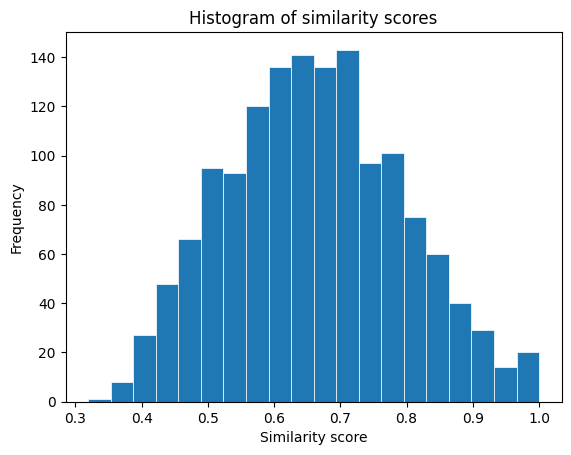

In [29]:
# create a histogram of the similarity scores

df_similarity_scores['similarity_score'].plot(kind='hist', bins=20, linewidth=0.5, edgecolor="white")
plt.xlabel('Similarity score')
plt.ylabel('Frequency')
plt.title('Histogram of similarity scores')

plt.show()


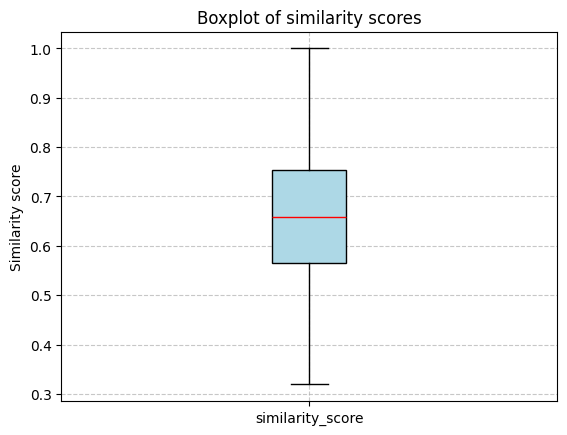

In [36]:
# create a boxplot of the similarity scores with improved styling
boxplot = df_similarity_scores.boxplot(column='similarity_score', patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'), medianprops=dict(color='red'), whiskerprops=dict(color='black'), capprops=dict(color='black'))

plt.ylabel('Similarity score')
plt.title('Boxplot of similarity scores')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()